# Compare models

## Loading feature sets

In [1]:
# defining constants
corpus_folder='corpus'
metadata_fn='corpus/metadata.txt'
target_col='sample_name'
dir_featuresets='featuresets'
kf_n_splits=5

In [2]:
# imports
import pandas as pd,os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
# open all metadata and featuresets
df_meta=pd.read_csv(metadata_fn,encoding='utf-8',sep='\t').set_index('fn')
ALL_DFs = [(metadata_fn,df_meta)]
name2df={}
for fn in os.listdir(dir_featuresets):
    if fn.endswith('.txt'):
        name=fn.replace('.txt','')
        df=pd.read_csv(os.path.join(dir_featuresets,fn),encoding='utf-8',sep='\t').fillna(0)
        df = df.set_index('_fn' if '_fn' in df else 'fn')
        ALL_DFs+=[(fn,df)]
        name2df[name]=df

In [4]:
# the metadata
df_meta.shape

(1300, 9)

In [5]:
# The feature dfs
for name,df in name2df.items(): print name, df.shape

wordfreqs (1300, 1000)
poesy (1300, 165)


### Synchronize all dataframes (metadata + featuresets)

In [6]:
# Get indices/filenames that appear in every featureset
index_sets = [set(df.index) for (fn,df) in ALL_DFs]
shared_index = set.intersection(*index_sets)
shared_index = sorted(list(shared_index))

In [7]:
# How many shared indices are there?
len(shared_index)

1282

In [8]:
# Rebalance all dfs to just the shared index
df_meta=df_meta[~df_meta.index.duplicated(keep='first')]
df_meta=df_meta.loc[shared_index]
df_meta.reindex(shared_index)
for i in list(range(len(ALL_DFs))):
    fn,df=ALL_DFs[i]
    name=fn.replace('.txt','')
    print fn,df.shape,
    df=df[~df.index.duplicated(keep='first')]
    df=df.loc[shared_index]
    df.reindex(shared_index)
    ALL_DFs[i]=(fn,df)
    if i>0: name2df[name]=df
    print ALL_DFs[i][1].shape

corpus/metadata.txt (1300, 9) (1282, 9)
wordfreqs.txt (1300, 1000) (1282, 1000)
poesy.txt (1300, 165) (1282, 165)


In [9]:
# The metadata now
df_meta.shape

(1282, 9)

In [10]:
# The feature data frames and their shapes
[(name,df.shape) for name,df in name2df.items()]

[('wordfreqs', (1282, 1000)), ('poesy', (1282, 165))]

## Add derivative featuresets

In [11]:
# Not including for now: performs about as well as the rule-based models

# # Make a just 'lineX--rhymeswith-->lineY' featureset
# qcols_poesy=list(name2df['poesy'].select_dtypes('number').columns)
# qcols_poesy=[x for x in qcols_poesy if x.startswith('rhymes_')]
# name2df['poesy (just rhyme)']=name2df['poesy'][qcols_poesy]
# #qcols_poesy

In [12]:
# add combinations
name2df['poesy + wordfreqs']=name2df['poesy'].join(name2df['wordfreqs'])

## Classify!

In [13]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import numpy as np

# basic classifier
def classify(Xdf,y,return_probs=False,standardize=True,leave_one_out=False,n_splits=kf_n_splits):
    """
    This is a very basic logisticregression model
    using leave-one-out cross-validation to make predictions.
    
    X: matrix of numerical data
    y: true classes for data (Sonnets, NotSonnets, ...)
    return_probs: return probability of guess rather than guess itself
    """
    loo=LeaveOneOut()
    kf = KFold(n_splits=n_splits,shuffle=True,random_state=11)
    all_predictions=[]
    all_probs=[]
    ind2prob={}
    ind2pred={}
    
    cols=Xdf.columns
    if standardize:
        from scipy.stats import zscore
        X=zscore(Xdf.values)
        
    from collections import defaultdict
    all_coeffs=defaultdict(list)
    #for train_index, test_index in loo.split(X):
    splitter = loo.split(X) if leave_one_out else kf.split(X)
    
    for train_index,test_index in splitter:
        # build new model
        clf = LogisticRegression(C=0.001)
        # slice
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        Xdf_train, Xdf_test = Xdf.iloc[train_index], Xdf.iloc[test_index]
        # fit
        clf.fit(X_train,y_train)
        probs=clf.predict_proba(X_test)
        predictions=clf.predict(X_test)
        #return clf,probs,predictions
        
        if leave_one_out:
            # predict probs
            prob=probs[0][1]
            all_probs+=[prob]
            # predict vals
            prediction=predictions[0]
            all_predictions+=[prediction]
            # get feature coefficients
        else:
            this_predictions=list(predictions)
            this_probs=[prob[1] for prob in probs]
            for i,index in enumerate(Xdf_test.index):
                ind2pred[index]=this_predictions[i]
                ind2prob[index]=this_probs[i]
            
        for col,coef in zip(cols,clf.coef_[0]): all_coeffs[col]+=[coef]
    # reorder if KF
    if not leave_one_out:
        all_predictions=[ind2pred[ind] for ind in Xdf.index]
        all_probs=[ind2prob[ind] for ind in Xdf.index]
    # avg feature coefficients
    for cf in all_coeffs: all_coeffs[cf]=np.mean(all_coeffs[cf])
    # return all this data
    return (all_predictions,all_probs,all_coeffs)

In [14]:
# Run classifier on a featureset
def classify_feat_df(df_feat,return_probs=False):
    y=np.array([df_meta.loc[idx][target_col] for idx in shared_index])
    Xdf=df_feat.select_dtypes('number').fillna(0)
    return classify(Xdf,y,return_probs=return_probs)

In [15]:
#all_predictions,all_probs,all_coeffs=classify_feat_df(name2df['poesy'])
#all_coeffs

In [16]:
# Initiate results and probabilities dataframe
df_results=pd.DataFrame(index=shared_index)
df_probs=pd.DataFrame(index=shared_index)
df_results[target_col]=df_meta[target_col]
df_probs[target_col]=df_meta[target_col]

In [17]:
# Classify all feature DFs and get all data
ld_feats=[]
feats_sofar=set()
for name,df in name2df.items():
    print '>> featureset:',name,'...'
    #if 'wordfreqs' in name: continue

    # classify
    preds,probs,featd=classify_feat_df(df)
    
    # save data
    df_results[name]=preds
    df_probs[name]=probs
    
    # save data about feature coefficients
    if not '+' in name:
        for feat,coef in featd.items():
            if feat in feats_sofar: continue
            feats_sofar|={feat}
            d_feats={'feat':feat,'model':name,'coeff':coef}
            ld_feats+=[d_feats]
df_feats=pd.DataFrame(ld_feats)
df_feats['coeff_abs']=df_feats['coeff'].abs()

>> featureset: wordfreqs ...
>> featureset: poesy + wordfreqs ...
>> featureset: poesy ...


In [18]:
# Featureset of qualitative predictions
df_results.head()

,sample_name,wordfreqs,poesy + wordfreqs,poesy
corpus/NotSonnets/Z200137254.txt,NotSonnets,NotSonnets,NotSonnets,NotSonnets
corpus/NotSonnets/Z200137556.txt,NotSonnets,NotSonnets,NotSonnets,Sonnets
corpus/NotSonnets/Z200137669.txt,NotSonnets,NotSonnets,NotSonnets,NotSonnets
corpus/NotSonnets/Z200139458.txt,NotSonnets,Sonnets,NotSonnets,NotSonnets
corpus/NotSonnets/Z200139509.txt,NotSonnets,NotSonnets,NotSonnets,NotSonnets


In [19]:
# Featureset of probabilities for sonnet
df_probs.head(5)

,sample_name,wordfreqs,poesy + wordfreqs,poesy
corpus/NotSonnets/Z200137254.txt,NotSonnets,0.306367,0.242882,0.311310
corpus/NotSonnets/Z200137556.txt,NotSonnets,0.343467,0.461445,0.572219
corpus/NotSonnets/Z200137669.txt,NotSonnets,0.442241,0.221353,0.178019
corpus/NotSonnets/Z200139458.txt,NotSonnets,0.521884,0.259961,0.262423
corpus/NotSonnets/Z200139509.txt,NotSonnets,0.482544,0.426656,0.489357


In [20]:
# Most to least predictive features
df_feats.sort_values('coeff_abs',ascending=False)

,coeff,feat,model,coeff_abs
1030,0.091062,meter_length_avg_line,poesy,0.091062
1043,0.091062,meter_length_avg_parse,poesy,0.091062
1118,-0.083521,rhymes_l11-l12,poesy,0.083521
1057,-0.081263,rhyme_scheme_acc_Couplet,poesy,0.081263
1081,0.077080,rhymes_l05-l08,poesy,0.077080
...,...,...,...,...
436,0.000092,youth,wordfreqs,0.000092
829,0.000082,hair,wordfreqs,0.000082
914,0.000072,enough,wordfreqs,0.000072
1003,-0.000033,rhymes_l06-l13,poesy,0.000033


## Adding rule-based models

In [21]:
def poesy_rule_based_classifier_for_sonnets(row):
    if row['num_lines']!=14: return 'NotSonnets'
    #if row['meter_type_scheme']!='iambic': return 'NotSonnets'
    #if row['beat_scheme_repr']!='Pentameter': return 'NotSonnets'
    if row['meter_length_avg_line']<8: return 'NotSonnets'
    if row['meter_length_avg_line']>12: return 'NotSonnets'
    if not 'sonnet' in unicode(row['rhyme_scheme_name']).lower(): return 'NotSonnets'
    return 'Sonnets'

In [22]:
def loose_poesy_rule_based_classifier_for_sonnets(row,certainty_threshold=0.5,return_probs=False):
    counts_in_its_favor = []
    counts_in_its_favor += [row['num_lines']==14]
    counts_in_its_favor += [row['meter_type_scheme']=='iambic']
    counts_in_its_favor += [row['beat_scheme_repr']=='Pentameter']
    counts_in_its_favor += [row['meter_length_avg_line']>=8]
    counts_in_its_favor += [row['meter_length_avg_line']<=12]
    counts_in_its_favor += ['sonnet' in unicode(row['rhyme_scheme_name']).lower()]
    #counts_in_its_favor += ['sonnet' in unicode(row['rhyme_scheme_name']).lower()] # counts for double
    
    counts = [int(x) for x in counts_in_its_favor]
    certainty = sum(counts)/float(len(counts)) if counts else 0.0
    if return_probs: return certainty
    return 'Sonnets' if certainty>certainty_threshold else 'NotSonnets'

In [23]:
# Add rule based models' predictions to df_results
df_results['rule-based']=[
    poesy_rule_based_classifier_for_sonnets(row) for ind,row in name2df['poesy'].iterrows()
]
df_results['rule-based (loose)']=[
    loose_poesy_rule_based_classifier_for_sonnets(row) for ind,row in name2df['poesy'].iterrows()
]

In [24]:
# Add rule-based models' probabilities to df_probs
df_probs['rule-based']=[
    float(int(poesy_rule_based_classifier_for_sonnets(row)=='Sonnets')) for ind,row in name2df['poesy'].iterrows()
]

#loosely rule based
df_probs['rule-based (loose)']=[
    loose_poesy_rule_based_classifier_for_sonnets(row,return_probs=True) for ind,row in name2df['poesy'].iterrows()
]

In [25]:
# Results table now
df_results.head(5)

,sample_name,wordfreqs,poesy + wordfreqs,poesy,rule-based,rule-based (loose)
corpus/NotSonnets/Z200137254.txt,NotSonnets,NotSonnets,NotSonnets,NotSonnets,NotSonnets,NotSonnets
corpus/NotSonnets/Z200137556.txt,NotSonnets,NotSonnets,NotSonnets,Sonnets,Sonnets,Sonnets
corpus/NotSonnets/Z200137669.txt,NotSonnets,NotSonnets,NotSonnets,NotSonnets,NotSonnets,NotSonnets
corpus/NotSonnets/Z200139458.txt,NotSonnets,Sonnets,NotSonnets,NotSonnets,NotSonnets,Sonnets
corpus/NotSonnets/Z200139509.txt,NotSonnets,NotSonnets,NotSonnets,NotSonnets,NotSonnets,Sonnets


In [26]:
# Probability table now
df_probs.head(5)

,sample_name,wordfreqs,poesy + wordfreqs,poesy,rule-based,rule-based (loose)
corpus/NotSonnets/Z200137254.txt,NotSonnets,0.306367,0.242882,0.311310,0.0,0.500000
corpus/NotSonnets/Z200137556.txt,NotSonnets,0.343467,0.461445,0.572219,1.0,0.833333
corpus/NotSonnets/Z200137669.txt,NotSonnets,0.442241,0.221353,0.178019,0.0,0.500000
corpus/NotSonnets/Z200139458.txt,NotSonnets,0.521884,0.259961,0.262423,0.0,0.833333
corpus/NotSonnets/Z200139509.txt,NotSonnets,0.482544,0.426656,0.489357,0.0,0.833333


## Comparing Precision/Recall across models

### Table of precision/recall values

In [27]:
from sklearn.metrics import precision_recall_fscore_support

In [28]:
summaryld=[]
for col in df_results.columns:
    if col==target_col: continue
    sdx={}
    sdx['precision'],sdx['recall'],sdx['fscore'],sdx['support']=precision_recall_fscore_support(df_results[target_col], df_results[col], labels=['Sonnets'])
    for k,v in sdx.items(): sdx[k]=v[0]
    sdx['model']=col.replace('_',' ').title()
    summaryld+=[sdx]
summarydf=pd.DataFrame(summaryld)
summarydf=summarydf[['model','precision','recall','fscore']].sort_values('fscore',ascending=False).set_index('model')

In [29]:
summarydf.round(3)

,precision,recall,fscore
model,,,
Poesy + Wordfreqs,0.884,0.822,0.852
Poesy,0.853,0.801,0.826
Rule-Based,0.776,0.834,0.804
Rule-Based (Loose),0.577,0.969,0.723
Wordfreqs,0.707,0.700,0.703


### Plotting precision/Recall curves

In [30]:
from sklearn.metrics import precision_recall_curve
def prcurve(y_true,y_scores):
    return precision_recall_curve(list(y_true), y_scores.values, pos_label='Sonnets')

In [35]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
#plt.figure(figsize=(600, ), dpi= 80, facecolor='w', edgecolor='k')

def plot_prcurve(y_true,y_scores,label,color='b'):
    from sklearn.utils.fixes import signature

    precision, recall, _ = prcurve(y_true,y_scores)
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score([int(yx=='Sonnets') for yx in y_true], y_scores)
    label = label.replace('_prob_sonnet','') + ' (AP=%s)' % round(average_precision,2)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color=color, alpha=1.0,
             where='post',label=label)
    #plt.fill_between(recall, precision, alpha=0.2, color=color, **step_kwargs)

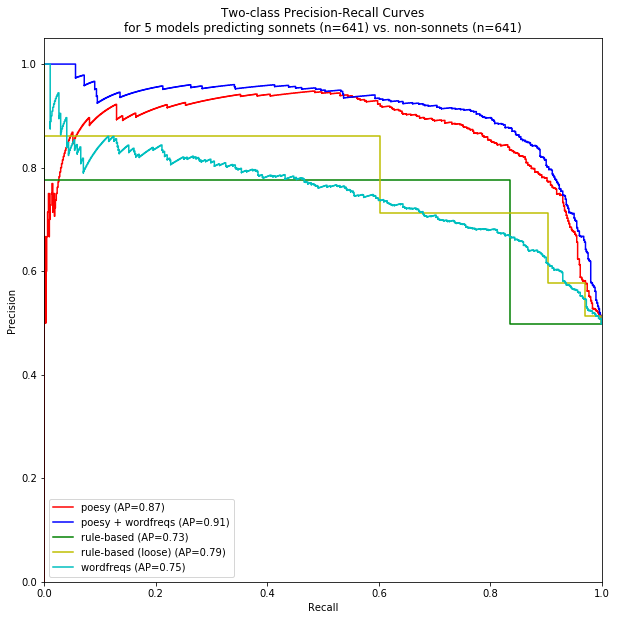

In [36]:
#plot_prcurve(df_probs[target_col], df_probs['poesy_prob_sonnet'])
colors=['r','b','g','y','k','c','m']
for i,col in enumerate(sorted(df_probs)):
    if col==target_col: continue
    plot_prcurve(df_probs[target_col], df_probs[col],color=colors[i],label=col)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Two-class Precision-Recall Curves\nfor {nmodel} models predicting sonnets (n={nc1}) vs. non-sonnets (n={nc2})'.format(
            nmodel=len(df_probs.columns)-1,nc1=len(df_meta[target_col])/2,nc2=len(df_meta[target_col])/2
))
plt.legend()
plt.savefig('figure.png')
plt.show()

## Examining features

### Which are the top 10 best predictors of sonnets?

* Long lines (meter_length_avg_parse and meter_length_avg_line).
* Rhyming 5->8 (as in abbaCddC); 6->7 (abbacDDc); 1-4 (AbbA); 2->3 (aBBa); 2->6 (aBbaaBba [Petrarchan])
* Having a sonnet rhyme scheme (poesy finds best for rhyme scheme among [a list of rhyme schemes](https://github.com/quadrismegistus/poesy/blob/master/poesy/schemes/rhyme_schemes.txt).

In [33]:
df_feats[['feat','model','coeff','coeff_abs']].sort_values('coeff',ascending=False).round(3).head(10)

,feat,model,coeff,coeff_abs
1043,meter_length_avg_parse,poesy,0.091,0.091
1030,meter_length_avg_line,poesy,0.091,0.091
1081,rhymes_l05-l08,poesy,0.077,0.077
1107,rhyme_scheme_acc_Sonnet H,poesy,0.062,0.062
1128,rhymes_l06-l07,poesy,0.056,0.056
1140,rhymes_l01-l04,poesy,0.055,0.055
1064,rhymes_l02-l03,poesy,0.053,0.053
1038,"rhyme_scheme_acc_Sonnet, Petrarchan C",poesy,0.050,0.050
1060,rhymes_l02-l06,poesy,0.049,0.049
1036,"rhyme_scheme_acc_Sonnet, Petrarchan A",poesy,0.049,0.049


### Which are the top 25 best predictors of non-sonnets?

* Having couplets in the poem (many features are successive lines rhyming with each other).
* Having the fourth syllable be weak (meter_perc_lines_fourthpos_w), indicating a trochaic-like line, swsW or an anapestic one, wwsW.
* Having ternary feet (meter_mpos_ww).

In [34]:
df_feats[['feat','model','coeff','coeff_abs']].sort_values('coeff',ascending=True).round(3).head(10)

,feat,model,coeff,coeff_abs
1118,rhymes_l11-l12,poesy,-0.084,0.084
1057,rhyme_scheme_acc_Couplet,poesy,-0.081,0.081
1100,rhymes_l01-l02,poesy,-0.076,0.076
1022,rhymes_l05-l06,poesy,-0.070,0.070
1075,rhymes_l09-l10,poesy,-0.061,0.061
1150,rhymes_l07-l08,poesy,-0.060,0.060
1136,rhymes_l03-l04,poesy,-0.057,0.057
1032,rhymes_l13-l14,poesy,-0.056,0.056
1146,meter_perc_lines_fourthpos_w,poesy,-0.046,0.046
1127,meter_mpos_ww,poesy,-0.043,0.043
